## Exporation of large scientific dataset with OpenVisus and ITKwidgets

### OpenViSUS: install package

To execute this jupyter notebook have to install: OpenViSUS
```
python -m pip install OpenVisus

python -m OpenVisus configure
```

Note: ignore errors during the "configure" process

Alternatively, see below on how to install the packages directly from the jupyter notebook

### ITKwidgets: install package

You can install itkwidgets from the anaconda-navigator (environment tab, search for "itkwidgets" in "not installed packages).

Alternatively you can install it from an Anaconda console/prompt with:

`conda install itkwidgets`

### OpenViSUS: read from a remote dataset

In [110]:
%matplotlib notebook

import os,sys

# Here are commands to install a package (OpenVisus) directly from a jupyter notebook
# after you install those once you can comment those comment
!{sys.executable} -m pip install OpenVisus
#!{sys.executable} -m OpenVisus configure

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *

#from OpenVisus import *
import OpenVisus as ov

# Enable I/O component of OpenVisus
ov.DbModule.attach()

In [253]:
# function to read data from a remote dataset
# optional parameters: timestep, field (variable in the dataset), logic_box (bounding box of the query), resolution

# Note: the resolution value could sometime fetch a dataset with the wrong aspect ratio, 
# this because in the IDX format we double the size at each resolution on only one of the axis at a time

def readData(dataset,
    time=None,
    field=None,
    logic_box=ov.BoxNi(),
    resolution=None):
    
    # setting default values if not provided
    if(time==None):
        time=dataset.getDefaultTime()
    if(field==None):
        field=dataset.getDefaultField()
    if(logic_box==ov.BoxNi()):
        logic_box=dataset.getLogicBox()
    if(resolution==None):
        resolution=dataset.getMaxResolution()
    
    # create an access mode (default "network") to access the data
    access=dataset.createAccess()
    # define a box query to fetch data from a certain dataset, field and timestep
    query=ov.BoxQuery(dataset, field, time,ord('r'))
    # set the bounding box for our query
    query.logic_box=logic_box
    # set the resolution 
    query.end_resolutions.push_back(resolution)
    # prepare and execute the query
    dataset.beginQuery(query)
    dataset.executeQuery(access,query)

    # transform the result of the query to a numpy array
    data=ov.Array.toNumPy(query.buffer,bSqueeze=True,bShareMem=False)
    
    return data

# function to plot the image data with matplotlib
# optional parameters: colormap, existing plot to reuse (for more interactivity)
def showData(data, cmap=None, plot=None):
    if(plot==None or cmap!=None):
        fig=plt.figure(figsize = (7,7))
        plot = plt.imshow(data, origin='lower', cmap=cmap)
        plt.show()
        return plot
    else:
        plot.set_data(data)
        plt.show()
        return plot
    

### Navigate time and resolution

In [198]:
# select a remote dataset (satellite imagery from NASA)
# this doesn't actually fetch any data, only metadata
dataset=ov.LoadDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=BlueMarble")

# what is the size of this dataset ?
# the logic box contains the extent of the dataset on the different axis
dataset.getLogicBox().toString()

'0 86400 0 43200'

In [206]:
# what is the maximum resolution ? 
# NOTE: don't use large values of the resolution for large query (you will be fetching too much data)
dataset.getMaxResolution()

33

In [207]:
# what timesteps are defined
dataset.getTimesteps().toString()

'<DatasetTimesteps>\n\t<timestep from="0" to="11" step="1" />\n</DatasetTimesteps>'

<IPython.core.display.Javascript object>


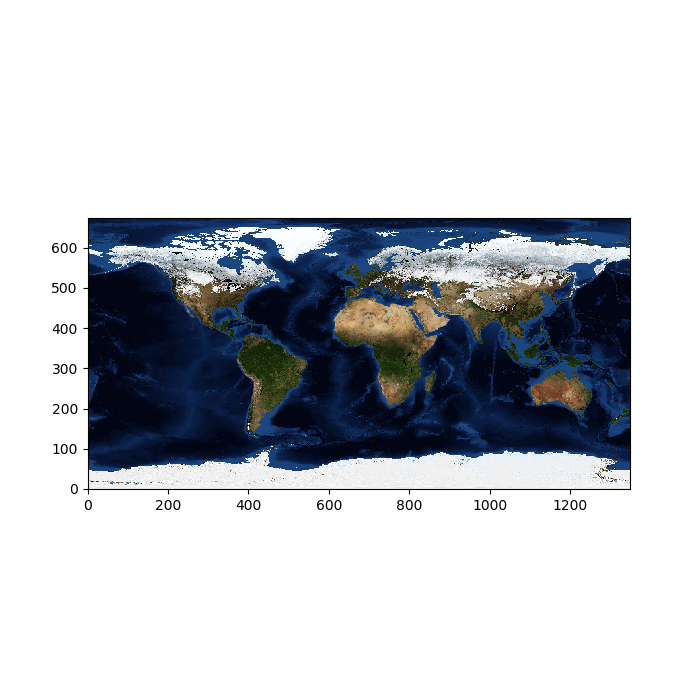

In [208]:
showData(readData(dataset, time=0, resolution=21))

<IPython.core.display.Javascript object>


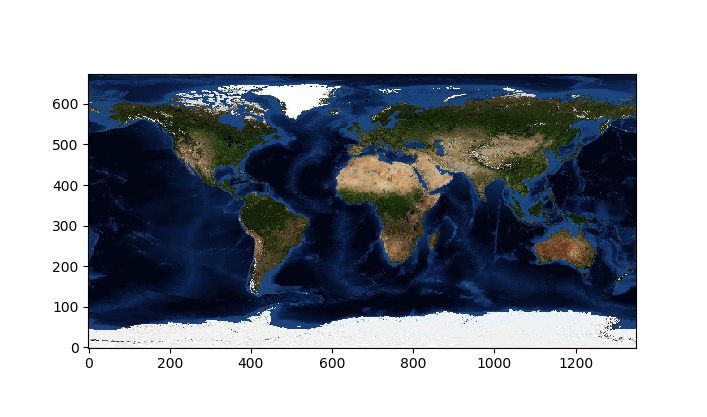

interactive(children=(IntSlider(value=0, description='time', max=11), IntSlider(value=9, description='resoluti…

<function __main__.<lambda>(time, resolution)>

In [209]:
# create a plot for our data
myplot = showData(readData(dataset, time=0, resolution=21))

# reuse the plot with an interact for varying time and resolution values
interact(
    lambda time,resolution: showData(readData(dataset,time=time,resolution=resolution), plot=myplot),
    time=widgets.IntSlider(value=0,min=0,max=11,step=1), 
    resolution=widgets.IntSlider(value=9,min=1,max=dataset.getMaxResolution(),step=2))

### Interactive analysis

In [211]:
# Open an aerial dataset from the National Ecology Observatory Network 
dataset=ov.LoadDataset("https://molniya.sci.utah.edu/mod_visus?dataset=neon_redb")
dataset.getLogicBox().toString()

'0 80000 0 100000'

<IPython.core.display.Javascript object>


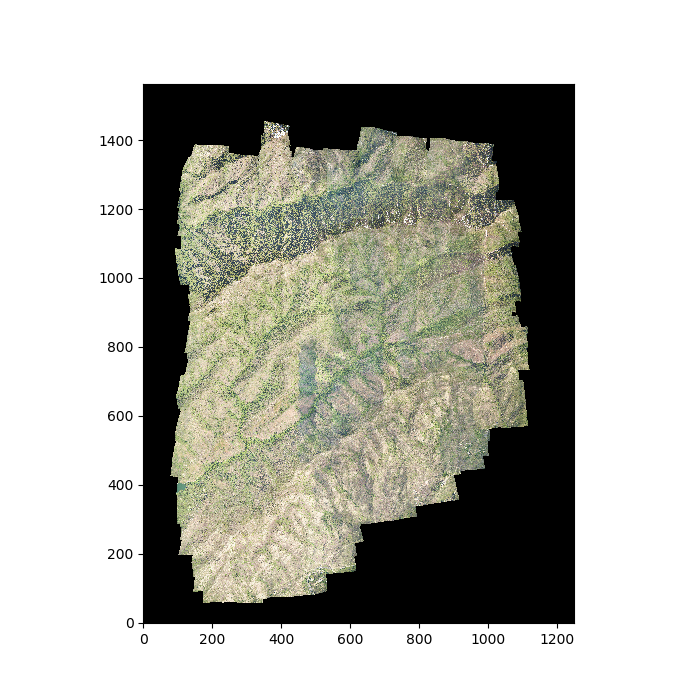

In [212]:
data = readData(dataset, resolution=22)
showData(data)

In [167]:
# what's the name of the field we are looking at?
dataset.getDefaultField().name

'DATA'

In [213]:
# what's the datatype fo this field?
dataset.getDefaultField().dtype.toString()

'uint8[3]'

In [214]:
# what's the size of the data fetched? (note: there are three channels, RGB)
data.shape

(1563, 1250, 3)

In [223]:
# make a "grey scale" version of the data
# from Matlab "rgb2gray" 0.2989 * R + 0.5870 * G + 0.1140 * B (standard ITU-R BT.601-7)

R,G,B=(0.2989*data[:,:,0], 0.5870*data[:,:,1], 0.1140*data[:,:,2])
grey_data=R+G+B

<IPython.core.display.Javascript object>


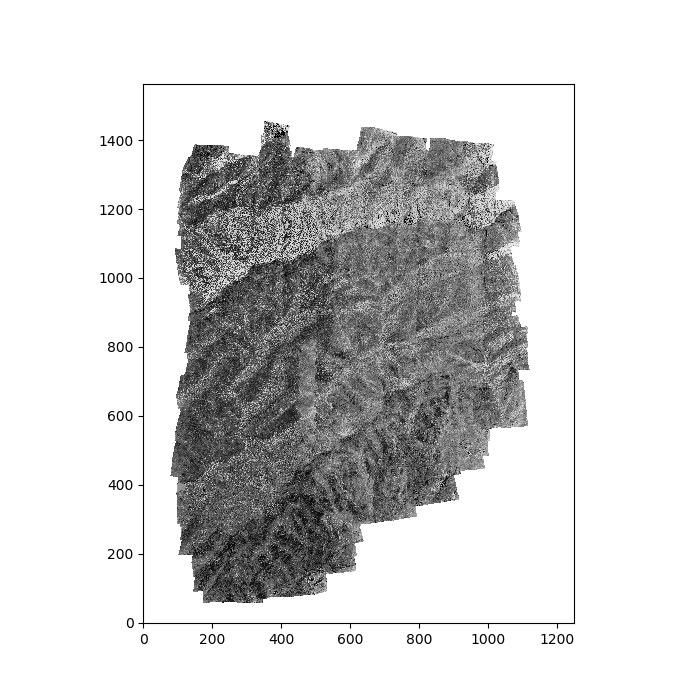

In [224]:
# show data using a grey scale colormap
showData(grey_data, cmap=plt.get_cmap("Greys"))

In [227]:
# make a threshold function to show which "pixel" is above a certain values
def threshold(data, t):
    return data > t

<IPython.core.display.Javascript object>


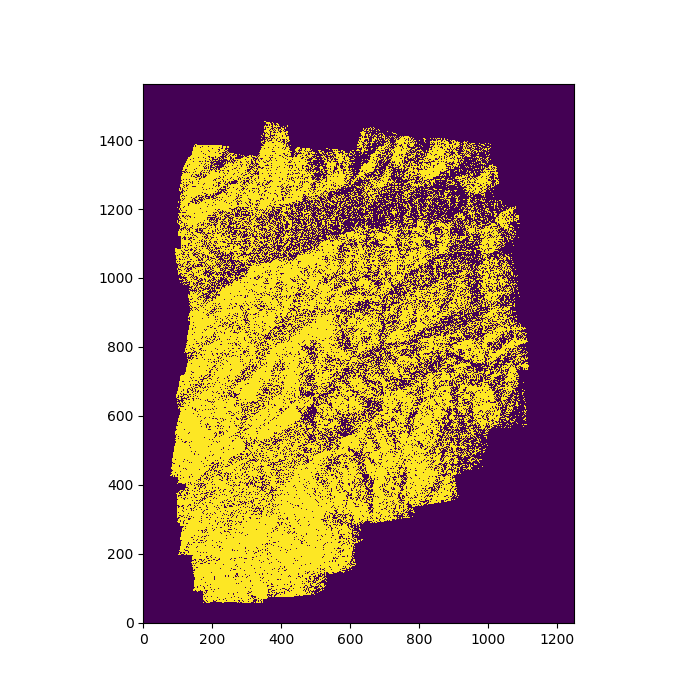

In [228]:
showData(threshold(grey_data, 150))

<IPython.core.display.Javascript object>


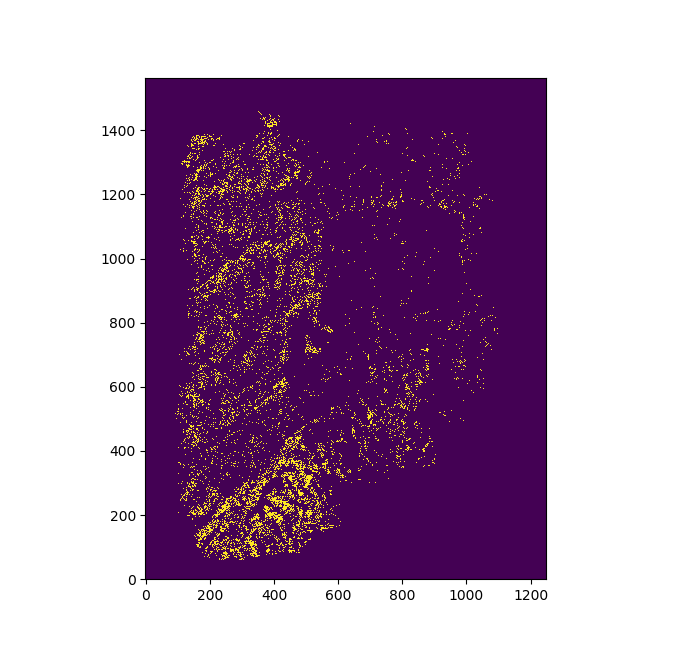

interactive(children=(IntSlider(value=96, description='thr', max=254), Output()), _dom_classes=('widget-intera…

<function __main__.<lambda>(thr)>

In [229]:
# make the threshold exploration interactive
myplot = showData(threshold(grey_data,t=150))

interact(
    lambda thr: showData(threshold(grey_data,t=thr), plot=myplot),
    thr=widgets.IntSlider(value=np.mean(grey_data),min=np.min(grey_data),max=np.max(grey_data),step=1))

### Working with 3D datasets

In [230]:
dataset=ov.LoadDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1")
# how big is the dataset ?
dataset.getLogicBox().toString()

'0 2048 0 2048 0 2048'

<IPython.core.display.Javascript object>


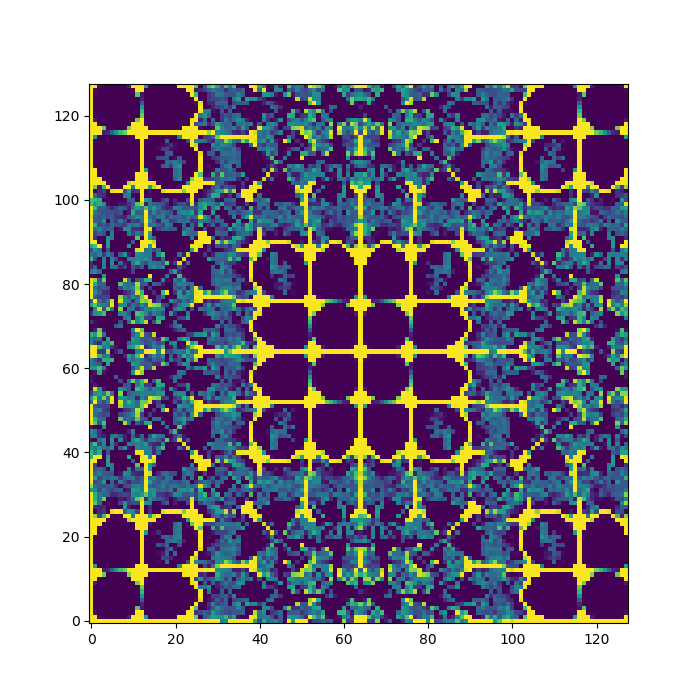

In [231]:
# make a query to fetch a slice of this 3D dataset (in the middle of the 3rd axis)
data=readData(dataset, logic_box=ov.BoxNi(ov.PointNi(0,0,1024),ov.PointNi(2048,2048,1025)),resolution=21)
showData(data)

### Use ITK widgets

In [234]:
# import itk libraries and the "view" function

import itk
from itkwidgets import view
import itkwidgets

In [235]:
# use itkwidgets to explore and visualize 2D data
view(data)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC2; proxy …

In [236]:
# read the entire dataset at a certain resolution
data=readData(dataset, resolution=24)

In [238]:
# show it in 3D
view(data, select_roi=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

In [258]:
# loading a large 2D microscopy dataset showing the retina of a rabbit
dataset=ov.LoadDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=rabbit")
# how big is the dataset ?
# the logic box contains the extent of the dataset on the different axis
dataset.getLogicBox().toString()

'0 131072 0 131072'

In [241]:
# get default field name
dataset.getDefaultField().name

'EM'

In [242]:
# get default field datatype 
dataset.getDefaultField().dtype.toString()

'uint8'

In [243]:
data=readData(dataset, resolution=22)
view(data)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC2; proxy …

In [244]:
# open a 3D version of this dataset
dataset=ov.LoadDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=rabbit3d")
# how big is the dataset ?
# the logic box contains the extent of the dataset on the different axis
dataset.getLogicBox().toString()

'0 131072 0 131072 0 341'

In [246]:
# almost 6TB size, can we still visualize it on this browser?
131073*131073*342/(1024*1024*1024)

5472.083496412262

In [248]:
data=readData(dataset, resolution=21)
view(data)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

### Voxel spacing

Microscopy data or CT scan often have different resolution along the axis, in order to make a realistic visualization we need to use correct voxel spacing

In [249]:
# to edit the voxel spacing we need to transform our numpy array into an itk data structure
itk_array = itk.image_from_array(data)
# read the current spacing (uniform)
itk_array.GetSpacing()

itkVectorD3 ([1, 1, 1])

In [250]:
# set a new spacing
itk_array.SetSpacing([1.0, 1.0, 0.1])
view(itk_array)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

In [254]:
# we open a metallic foam dataset
dataset=ov.LoadDataset("https://molniya.sci.utah.edu/mod_visus?dataset=foam")
# how big is the dataset ?
# the logic box contains the extent of the dataset on the different axis
dataset.getLogicBox().toString()

'0 1055 0 1024 0 1024'

In [257]:
# Visualize and explore the dataset 
# How can we evaluate the density of material?

data=readData(dataset, resolution=22)
view(data, select_roi=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUS3; proxy …

In [185]:
# Evaluate the density of material 
count = (data > 23000).sum()
density = count/(data.shape[0]*data.shape[1]*data.shape[2])
density


0.044780846798058715

In [186]:
def density_res(res):
    data=readData(dataset, resolution=res)
    count = (data > 23000).sum()
    density = count/(data.shape[0]*data.shape[1]*data.shape[2])
    return density

In [187]:
density_res(21)

0.044757265033143936

In [188]:
density_res(20)

0.04464074337121212

In [189]:
density_res(18)

0.04525479403409091

In [190]:
density_res(17)

0.04532137784090909

In [191]:
density_res(15)

0.043619791666666664

In [192]:
density_res(10)

0.052083333333333336

### Run client OpenVisus Viewer 

#### Note: the following does not work in a remote environment (e.g.,  Binder or JupyterHub), you can try the following code downloading this jupyter notebook and running it locally (after installing the dependencies OpenVisus and ITKwidgets, see beginning of this page)

In [50]:
from OpenVisus import *
from VisusGuiPy	     import *
from VisusGuiNodesPy import *
from VisusAppKitPy   import *
from OpenVisus.VisusGuiPy      import *
from OpenVisus.VisusGuiNodesPy import *
from OpenVisus.VisusAppKitPy   import *

In [51]:
SetCommandLine("__main__")
GuiModule.createApplication()
AppKitModule.attach()  
viewer=Viewer()
# select dataset to open with the viewer
viewer.open("https://molniya.sci.utah.edu/mod_visus?dataset=foam") 
GuiModule.execApplication()

Array 66 64 64 
Array 132 128 128 
Array 264 256 256 
